# Statistics of Polymer Models
## Nikolas Schnellbächer (last revision 2018-07-16)

In this notebook we explore some statistical properties of two simple polymer models, the freely jointed chain (FJC) model and the freely rotating chain (FRC) model. 
We use random walk algorithms to numerically sample trajectories for both models.
In all cases $N$ denotes the number of chain segments and $a$ is the segment length. For the freely rotating chain model $\theta$ is the rotation angle. Here we work in two dimensions exclusively. An extension to $d = 3$ or $d = 1$ is straight forward.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# define measurement functions here

def get_msd(X, Y, sampleLengths):
    '''
    Calculates the mean squared displacement of two-dimensional trajectories.
    '''
    msd = np.zeros((len(sampleLengths),))
    
    for i in range(len(sampleLengths)):
    
        msd[i] = np.mean(np.square(X[i, :]) + np.square(Y[i, :]))
    
    return msd

def FloryC(theta):
    '''
    Flory's characterictic ratio $C_{\infty}$ for a freely rotating chain (FRC).
    '''
    return (1.0 + np.cos(theta)) / (1.0 - np.cos(theta))

In [3]:
def FJC(sampleLengths, m, a = 1.0e-3, x0 = 0.0, y0 = 0.0):
    '''
    Random walk model for the freely jointed chain (FJC) in two dimensions (d = 2).
    '''
    nSamples = len(sampleLengths)
    iterations = (sampleLengths).astype(int)
    iterations[1:] = iterations[1:] - iterations[0:-1]
    totalIterations = np.cumsum(iterations)[-1]
    print("totalIterations = ",totalIterations)
    
    LOW, HIGH = 0.0, 2.0 * np.pi
    
    outx = np.zeros((nSamples, m))
    outy = np.zeros((nSamples, m))
    
    for k in range(m):
        
        x, y = x0, y0 # set initial position
        
        for j in range(nSamples):
            
            for i in range(iterations[j]):
                
                phi = np.random.uniform(low = LOW, high = HIGH)
                
                x += a * np.cos(phi)
                y += a * np.sin(phi)
                
            outx[j, k] = x
            outy[j, k] = y
    
    return outx, outy

In [4]:
def FJC_vec(sampleLengths, m, a = 1.0e-3, x0 = 0.0, y0 = 0.0):
    '''
    Random walk model for the freely jointed chain (FJC) in two dimensions (d = 2).
    Vectorized version of the FJC algorithm.
    The m statistically independent trajectories are updated simultaneously.
    '''
    nSamples = len(sampleLengths)
    iterations = (sampleLengths).astype(int)
    iterations[1:] = iterations[1:] - iterations[0:-1]
    totalIterations = np.cumsum(iterations)[-1]
    print("totalIterations = ",totalIterations)
    
    LOW, HIGH = 0.0, 2.0 * np.pi
    
    outx = np.zeros((nSamples, m))
    outy = np.zeros((nSamples, m))
    
    x = np.ones((1, m)) * x0
    y = np.ones((1, m)) * y0

    outx[0, :] = x
    outy[0, :] = y

    for j in range(nSamples):
            
        for i in range(iterations[j]):
                
            phis = np.random.uniform(low = LOW, high = HIGH, size = m)
                
            x += a * np.cos(phis)
            y += a * np.sin(phis)
                
            outx[j, :] = x
            outy[j, :] = y
    
    return outx, outy

To understand the implementation for the FRC algorithm (the unvectorized version) below recall that in two dimensions the standard rotation matrix $R(\theta)$ reads
\begin{align}
R(\theta) = \begin{pmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{pmatrix} \, .
\end{align}
The binary coin flip choice at each iteration then simply decides whether the current orientation is either rotated by $R_{+}:=R(+\theta)$ or by $R_{-}:=R(-\theta)$.
Given a starting orientation vector $\boldsymbol{f}$ we update the orientation by invoking
\begin{align}
\boldsymbol{f}_{i+1} = \begin{cases}
R_+ \cdot \boldsymbol{f}_{i} & \text{for}\quad p_{\text{coin}} > 0.5\\
R_- \cdot \boldsymbol{f}_{i} & \text{else}
\end{cases}
\end{align}
Then the position update follows immediately as
\begin{align}
\boldsymbol{x}_{i+1} = \boldsymbol{x}_i + a \cdot \boldsymbol{f}_{i+1} \, .
\end{align}
Here $\boldsymbol{x}$ and $\boldsymbol{f}$ are both two-dimensional position and orientation vectors, respectively.

In [5]:
def FRC(sampleLengths, m, a = 1.0e-3, theta = 0.2 * np.pi, x0 = 0.0, y0 = 0.0):
    '''
    Random walk model for the freely rotating chain (FRC) in two dimensions (d = 2).
    '''
    nSamples = len(sampleLengths)
    iterations = (sampleLengths).astype(int)
    iterations[1:] = iterations[1:] - iterations[0:-1]
    totalIterations = np.cumsum(iterations)[-1]
    print("totalIterations = ",totalIterations)
    
    LOW, HIGH = 0.0, 2.0 * np.pi
    
    outx = np.zeros((nSamples, m))
    outy = np.zeros((nSamples, m))
    
    # make sure to precalculate R0 and R1 outside of the for loops below!
    R0 = np.matrix([[np.cos(theta), -np.sin(theta)],\
                    [np.sin(theta), np.cos(theta)]])
    R1 = np.matrix([[np.cos(-theta), -np.sin(-theta)],\
                    [np.sin(-theta), np.cos(-theta)]])
    
    for k in range(m):
        
        x = np.array([[x0], [y0]]) # set initial position
        phi = np.random.uniform(LOW, HIGH)
        ori = np.array([[np.cos(phi)],[np.sin(phi)]])
        
        for j in range(nSamples):
            
            for i in range(iterations[j]):
                
                flip = np.random.choice([0, 1])
                
                if (flip == 1):
                    ori = np.dot(R1, ori)
                else:
                    ori = np.dot(R0, ori)

                x += a * ori
            
            outx[j, k] = x[0]
            outy[j, k] = x[1]
    
    return outx, outy

The implementation of the FRC function above is a very literal and explicit implementation. It is a straight forward implementation of the described formulaes and very literally implements the algorithm.
This makes it clear to understand what is going on, at the expense of computational speed. Below I show you a vectorized version for the FRC model, which is much faster and hence recommended for more extensive statistical analysis of the model.

In [6]:
def FRC_vecSingle(N, a = 1.0e-3, theta = 0.2 * np.pi, x0 = 0.0, y0 = 0.0):
    '''
    Random walk model for the freely rotating chain (FRC) in two dimensions (d = 2).
    Vectorized version for a single trajectory (polymer).
    '''
    outx = np.zeros((N + 1,))
    outy = np.zeros((N + 1,))
    
    # initialize the random walker at the origin
    outx[0], outy[0] = x0, y0
    
    angles = np.zeros((N))
    # initial orientation uniformly sampled in [0, 2 * Pi)
    angles[0] = np.random.uniform(0.0, 2.0 * np.pi) 
    angles[1:] = theta * np.random.choice([-1.0, 1.0], N - 1)
    
    angles = np.cumsum(angles)
    outx[1:] = np.cumsum(a * np.cos(angles))
    outy[1:] = np.cumsum(a * np.sin(angles))

    return outx, outy

def FRC_wrapper(sampleIndices, m, a = 1.0e-3,\
                theta = 0.2 * np.pi, x0 = 0.0, y0 = 0.0):
    '''
    Wrapper function which creates m statistically 
    independent realizations of the FRC model.
    '''
    xVals = np.zeros((len(sampleIndices), m))
    yVals = np.zeros((len(sampleIndices), m))
    
    N = sampleIndices[-1]
    
    for i in range(m):
        tmpX, tmpY = FRC_vecSingle(N, a, theta, x0, y0)
        xVals[:, i] = tmpX[sampleIndices]
        yVals[:, i] = tmpY[sampleIndices]
    
    return xVals, yVals

In [7]:
def plot_trajectories(X, Y, m = 10):
    """
    Plotting routine that roots all polymer trajectories at the origin to create
    a spider/track-plot of all m trajectories at the same time.
    """
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 5.5)
    
    ax.set_xlabel('$x$ coordinate', fontsize = 18)
    ax.set_ylabel('$y$ coordinate', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    for i in range(m):
        ax.plot(X[:, i], Y[:, i], lw = 1.0, alpha = 0.80)

    rx = np.max(X)
    ry = np.max(Y)
    r = np.max([rx, ry])
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    return None

## Assay 1 -  Random walk model for the FJC

In [15]:
%%time
np.random.seed(123456789)
# create m = 25 FJC polymer configurations
m = 25
sampleLengths = np.arange(0.0, 501.0, 1)
X1, Y1 = FJC(sampleLengths, m)

totalIterations =  500
CPU times: user 84.3 ms, sys: 5.34 ms, total: 89.6 ms
Wall time: 96.9 ms


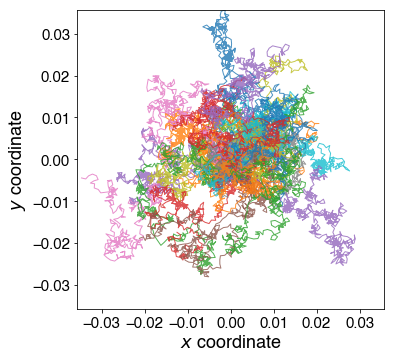

In [16]:
m = 25
plot_trajectories(X1, Y1, m)

In [19]:
%%time
np.random.seed(923456789)
# We repeat this assay from above, to demonstrate that the vectorized FJC algorithm version works equally.
# create m = 25 FJC polymer configurations
m = 25
sampleLengths = np.arange(0.0, 501.0, 1)
X1vec, Y1vec = FJC_vec(sampleLengths, m)

totalIterations =  500
CPU times: user 13.4 ms, sys: 3.76 ms, total: 17.2 ms
Wall time: 14.5 ms


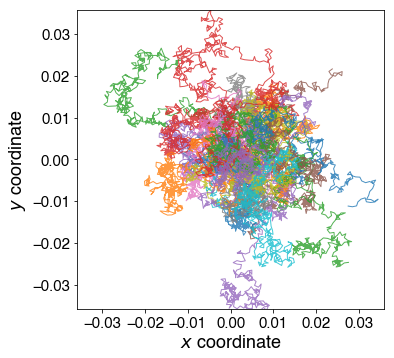

In [20]:
m = 25
plot_trajectories(X1vec, Y1vec, m)

## Random walk model for the FRC

In [12]:
%%time
np.random.seed(123456789)
# create m = 25 FRC polymer configurations
m = 25
sampleLengths = np.arange(0.0, 501.0, 1)
X2, Y2 = FRC(sampleLengths, m, theta = 0.1 * np.pi)

totalIterations =  500
CPU times: user 325 ms, sys: 32.1 ms, total: 357 ms
Wall time: 337 ms


In [13]:
%%time
# We repeat the same, using the vectorized version of the FRC algorithm.
np.random.seed(223456789)
# create m = 25 FJC polymer configurations
m = 25
sampleIndices = np.arange(0.0, 501.0, 1).astype(int)
X2_vec, Y2_vec = FRC_wrapper(sampleIndices, m, a = 1.0e-3, theta = 0.1 * np.pi)

CPU times: user 4.88 ms, sys: 1.02 ms, total: 5.9 ms
Wall time: 5.18 ms


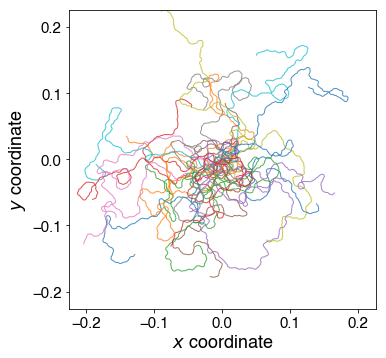

In [14]:
m = 25
plot_trajectories(X2, Y2, m)

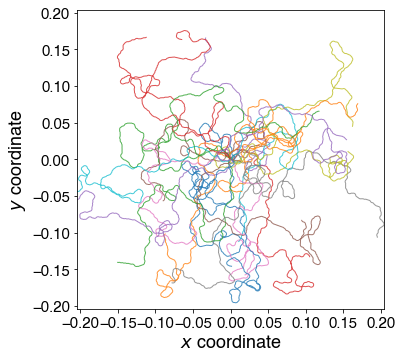

In [15]:
m = 25
plot_trajectories(X2_vec, Y2_vec, m)

(501, 25)
(501, 25)


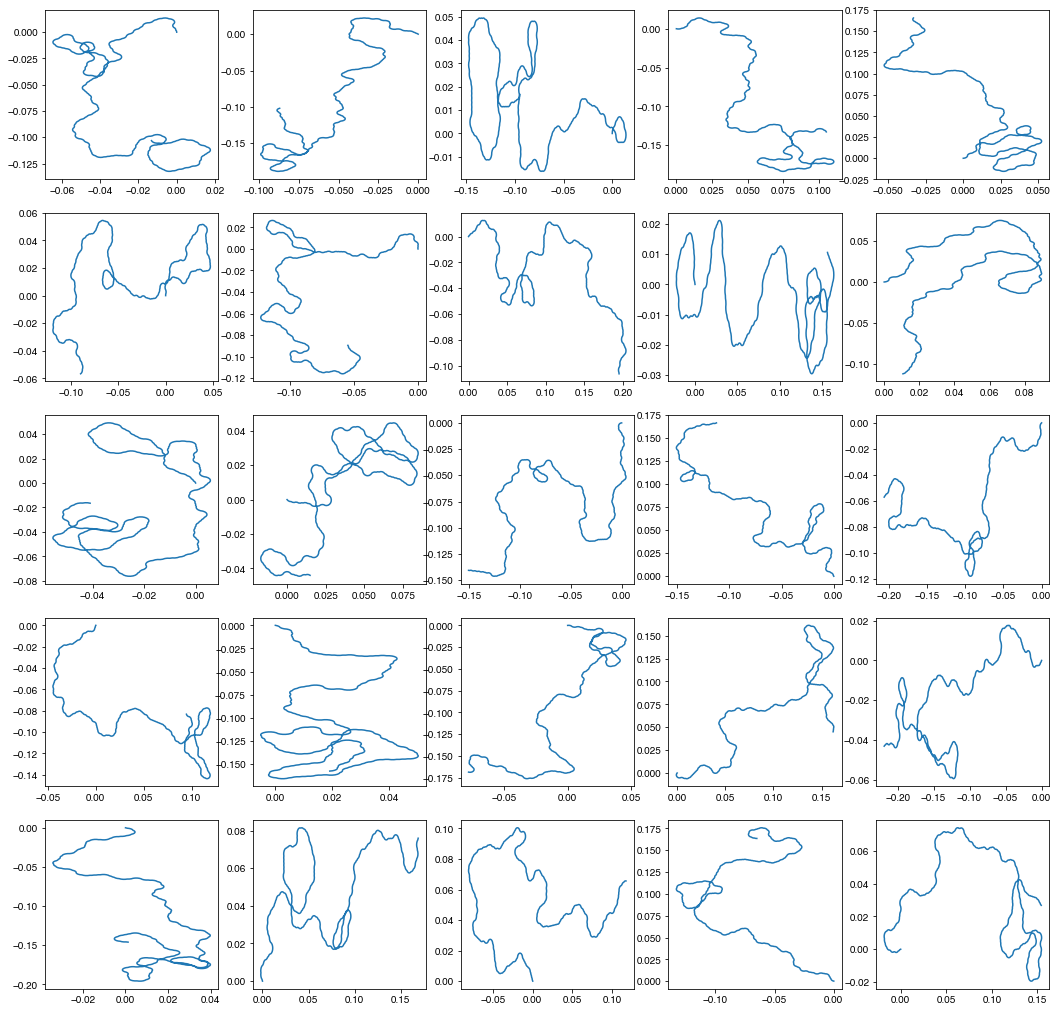

In [16]:
# separate plotting for m = 25 polymer chains
print(X2_vec.shape)
print(Y2_vec.shape)
f, ax = plt.subplots(5, 5, figsize = (18.0, 18.0))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.plot(X2_vec[:, i], Y2_vec[:, i])

In [17]:
%%time
np.random.seed(923456789)
# create m = 50 FRC polymer configurations
m = 50
sampleIndices = np.arange(0.0, 501.0, 1).astype(int)
X3_vec, Y3_vec = FRC_wrapper(sampleIndices, m, theta = 0.01 * np.pi)

CPU times: user 7.86 ms, sys: 1.11 ms, total: 8.98 ms
Wall time: 8.14 ms


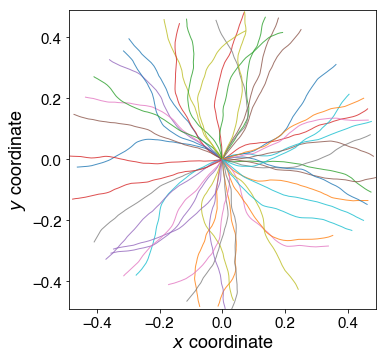

In [18]:
m = 50
plot_trajectories(X3_vec, Y3_vec, m)

In [19]:
%%time
np.random.seed(123456789)
# create m = 100 FRC polymer configurations
m = 100
sampleIndices = np.arange(0.0, 501.0, 1).astype(int)
X3_vec, Y3_vec = FRC_wrapper(sampleIndices, m, theta = 0.001
             * np.pi)

CPU times: user 12 ms, sys: 1.31 ms, total: 13.4 ms
Wall time: 12.3 ms


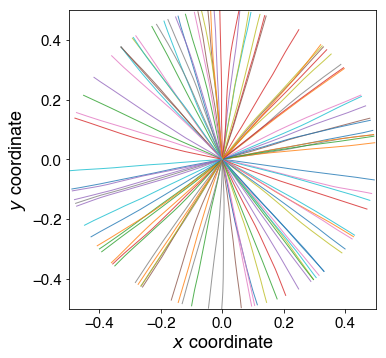

In [23]:
m = 100
plot_trajectories(X3_vec, Y3_vec, m)

Changing the rotation angle $\theta$ we can change the polymers persitence lenght $l_P$.
The well established relation for the freely rotating chain model reads
\begin{align}
l_P = -\dfrac{a}{\ln\left(\cos\theta\right)} \, .
\end{align}

In [20]:
%%time
np.random.seed(123456789)
# create m = 25 FRC polymer configurations
m = 10
sampleIndices = np.arange(0.0, 501.0, 1).astype(int)
X3_vec, Y3_vec = FRC_wrapper(sampleIndices, m, theta = 0.5 * np.pi)

CPU times: user 2.48 ms, sys: 654 µs, total: 3.13 ms
Wall time: 2.7 ms


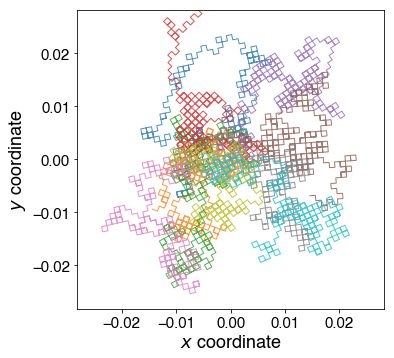

In [21]:
m = 10
plot_trajectories(X3_vec, Y3_vec, m)

In [22]:
%%time
np.random.seed(123456789)
# create m = 25 FRC polymer configurations
m = 10
sampleIndices = np.arange(0.0, 501.0, 1).astype(int)
X3_vec, Y3_vec = FRC_wrapper(sampleIndices, m, theta = 0.75 * np.pi)

CPU times: user 2.57 ms, sys: 691 µs, total: 3.26 ms
Wall time: 2.86 ms


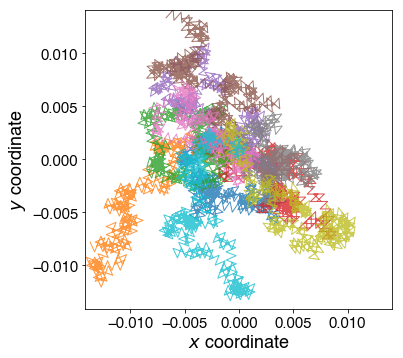

In [23]:
m = 10
plot_trajectories(X3_vec, Y3_vec, m)

## Assay 2 - FJC mean-squared-end-to-end vector as a function of chain length $N$

Next, we analyze the mean-squared end-to-end vector as a function of segment length. The goal is of course to verify, that the well known relation
\begin{align}
\bigl\langle
\boldsymbol{R}^2\,\bigl\rangle = Na^2
\end{align}
holds for the freely jointed chain (FJC). This is of course equivalent to 
\begin{align}
R = \sqrt{\bigl\langle
\boldsymbol{R}^2\,\bigl\rangle}
= \sqrt{N} a \, .
\end{align}
In the first part of this section on the FJC model we will show the $\sim N$ scaling and in the second part we verify the $\sim a^2$ scaling of the MSD.

In [24]:
%%time
np.random.seed(123456789)
m = 1000 # number of statistically independent configurations
sampleLengths = np.array([10, 500, 1000, 2500, 5000])

X_ex2, Y_ex2 = FJC(sampleLengths, m)

print(X_ex2.shape)
print(Y_ex2.shape)

totalIterations =  5000
(5, 1000)
(5, 1000)
CPU times: user 23.4 s, sys: 294 ms, total: 23.7 s
Wall time: 24.8 s


In [25]:
%%time
np.random.seed(123456789)
m = 1000 # number of statistically independent configurations
sampleLengths = np.array([10, 500, 1000, 2500, 5000])

X_ex2_vec, Y_ex2_vec = FJC_vec(sampleLengths, m)

print(X_ex2_vec.shape)
print(Y_ex2_vec.shape)

totalIterations =  5000
(5, 1000)
(5, 1000)
CPU times: user 420 ms, sys: 3.91 ms, total: 423 ms
Wall time: 427 ms


Here you can compare the execution time of the vectorized version against the execution time of the naive implementation of the FJC model. One gets a speed up of roughly 50 times faster code.

In [26]:
def plot_msd_FJC(X, Y, a = 1.0e-3):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('chain length $N$', fontsize = 18)
    ax.set_ylabel(r'$\langle R^2\rangle$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    ax.plot([-2.0, 6000.0], [a ** 2 * (-2.0), a ** 2 * (6000.0)], 
            lw = 2.0, 
            color = 'C0', 
            label = r'$\langle R^2\rangle = Na^2$', 
            zorder = 1)
    ax.scatter(X, Y, color = 'k', 
               s = 80,
               marker = 'o',
               facecolors = 'None',
               edgecolors = 'k',
               linewidth = 1.5,
               label = r'FJC (numeric)', zorder = 2)

    ax.set_xlim(-200.0, 5200.0)
    ax.set_ylim(-0.0005, 0.0062)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

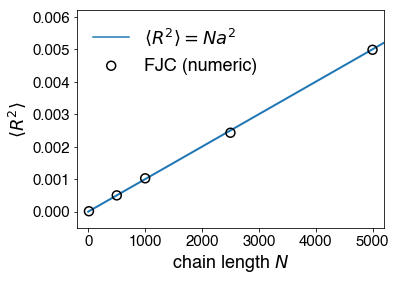

In [27]:
sampleLengths_ex2 = np.array([10, 500, 1000, 2500, 5000])
msd_ex2 = get_msd(X_ex2, Y_ex2, sampleLengths_ex2)
plot_msd_FJC(sampleLengths_ex2, msd_ex2, a = 1.0e-3)

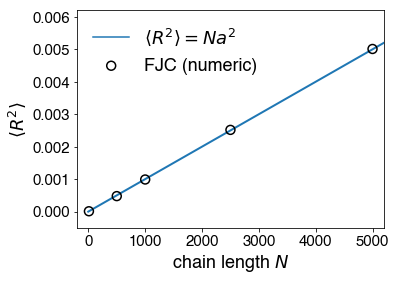

In [28]:
sampleLengths_ex2 = np.array([10, 500, 1000, 2500, 5000])
msd_ex2_vec = get_msd(X_ex2_vec, Y_ex2_vec, sampleLengths_ex2)
plot_msd_FJC(sampleLengths_ex2, msd_ex2_vec, a = 1.0e-3)

## Assay 3 FJC mean-squared-end-to-end vector as a function of the segment length $a$

In [29]:
%%time
np.random.seed(123456789)
m = 1000
N = 2000
sampleLengths_ex3 = np.array([N])
stepSizes_ex3 = np.array([1.0e-3, 2.0e-3, 3.0e-3, 5.0e-3, 7.5e-3, 1.0e-2])
res_ex3 = np.zeros((len(stepSizes_ex3)))
for i, a in enumerate(stepSizes_ex3):
    print("segment length", a)
    tmpX, tmpY = FJC(sampleLengths_ex3, m, a)
    msd = get_msd(tmpX, tmpY, sampleLengths_ex3)
    res_ex3[i] = msd[0]

segment length 0.001
totalIterations =  2000
segment length 0.002
totalIterations =  2000
segment length 0.003
totalIterations =  2000
segment length 0.005
totalIterations =  2000
segment length 0.0075
totalIterations =  2000
segment length 0.01
totalIterations =  2000
CPU times: user 53.1 s, sys: 390 ms, total: 53.5 s
Wall time: 54.1 s


In [30]:
%%time
np.random.seed(123456789)
m = 10000 # we can afford 10000 here
N = 2000
sampleLengths_ex3 = np.array([N])
stepSizes_ex3 = np.array([1.0e-3, 2.0e-3, 3.0e-3, 5.0e-3, 7.5e-3, 1.0e-2])
res_ex3_vec = np.zeros((len(stepSizes_ex3)))
for i, a in enumerate(stepSizes_ex3):
    print("segment length", a)
    tmpX, tmpY = FJC_vec(sampleLengths_ex3, m, a)
    msd = get_msd(tmpX, tmpY, sampleLengths_ex3)
    res_ex3_vec[i] = msd[0]

segment length 0.001
totalIterations =  2000
segment length 0.002
totalIterations =  2000
segment length 0.003
totalIterations =  2000
segment length 0.005
totalIterations =  2000
segment length 0.0075
totalIterations =  2000
segment length 0.01
totalIterations =  2000
CPU times: user 8.57 s, sys: 157 ms, total: 8.72 s
Wall time: 9.74 s


In [31]:
def plot_msd_FJC_a(X, Y, N = 2000.0):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)

    ax.set_xlabel('segment length $a$', fontsize = 18)
    ax.set_ylabel(r'$\langle R^2\rangle$', fontsize = 18)
    labelfontsize = 15.0
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    xVals = np.linspace(0.0, 1.05e-2, 500)
    yVals = np.array([N * a ** 2 for a in xVals])
    ax.plot(xVals, yVals, 
            lw = 2.0, color = 'C0', label = r'$\langle R^2\rangle = Na^2$')
    
    ax.scatter(X, Y, color = 'k', 
               s = 80,
               marker = 'o',
               facecolors = 'None',
               edgecolors = 'k',
               linewidth = 1.5,
               label = r'FJC (numeric)', zorder = 2)

    ax.set_xlim(0.0, 1.05e-2)
    #ax.set_ylim(-0.0005, 0.0062)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

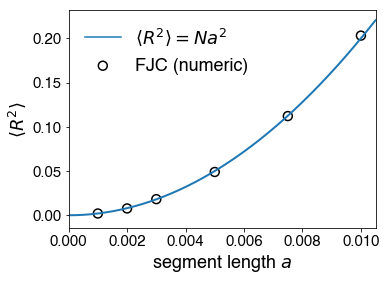

In [32]:
stepSizes_ex3 = np.array([1.0e-3, 2.0e-3, 3.0e-3, 5.0e-3, 7.5e-3, 1.0e-2])
plot_msd_FJC_a(stepSizes_ex3, res_ex3, N = 2000.0)

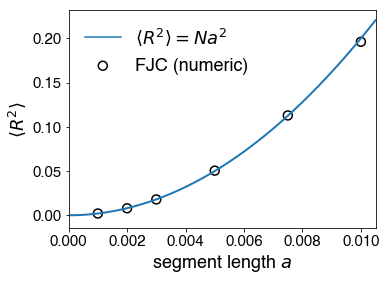

In [33]:
stepSizes_ex3 = np.array([1.0e-3, 2.0e-3, 3.0e-3, 5.0e-3, 7.5e-3, 1.0e-2])
plot_msd_FJC_a(stepSizes_ex3, res_ex3_vec, N = 2000.0)

## Assay 4 FRC mean-squared-end-to-end vector as a function of N

In [34]:
%%time
np.random.seed(923456789) # fix random seed
m = 2000 # number of independent configurations
sampleLengths_ex4 = np.array([10, 500, 1000, 2500, 5000])
X_ex4, Y_ex4 = FRC(sampleLengths_ex4, m)

np.savetxt('./assay_4_xdata.txt', X_ex4, fmt = '%.8f')
np.savetxt('./assay_4_ydata.txt', Y_ex4, fmt = '%.8f')

totalIterations =  5000
CPU times: user 3min 6s, sys: 1.77 s, total: 3min 7s
Wall time: 3min 10s


In [36]:
%%time
# vectorized version
np.random.seed(923456789) # fix random seed
m = 2000 # number of independent configurations
sampleLengths_ex4 = np.array([10, 500, 1000, 2500, 5000])
X_ex4_vec, Y_ex4_vec = FRC_wrapper(sampleLengths_ex4, m)

CPU times: user 811 ms, sys: 10.1 ms, total: 821 ms
Wall time: 839 ms


In [37]:
def plot_msd_FRC(X, Y, a = 1.0e-3, theta = 0.2 * np.pi):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel('chain length $N$', fontsize = 18)
    ax.set_ylabel(r'$\langle R^2\rangle$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    xVals = np.linspace(0.0, 6000.0, 500)
    yVals = np.array([N * a ** 2 * FloryC(theta) for N in xVals])
    ax.plot(xVals, yVals, 
            lw = 2.0, 
            color = 'C3',
            label = r'$\langle R^2\rangle = C_{\infty}(\theta)Na^2$',
            zorder = 1)
    
    ax.scatter(X, Y, color = 'k', 
               s = 80,
               marker = 'o',
               facecolors = 'None',
               edgecolors = 'k',
               linewidth = 1.5,
               zorder = 2,
               label = r'FRC (numeric)')

    ax.set_xlim(-200.0, 5200.0)
    #ax.set_ylim(-0.0005, 0.0062)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

In [38]:
file = './assay_4_xdata.txt'
X_ex4 = np.genfromtxt(file)
file = './assay_4_ydata.txt'
Y_ex4 = np.genfromtxt(file)

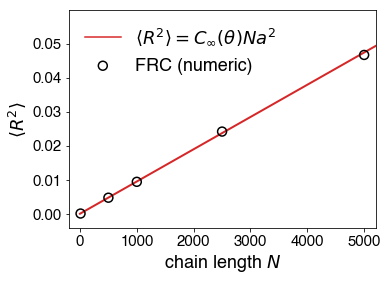

In [39]:
sampleLengths_ex4 = np.array([10, 500, 1000, 2500, 5000])
msd_ex4 = get_msd(X_ex4, Y_ex4, sampleLengths_ex4)
plot_msd_FRC(sampleLengths_ex4, msd_ex4)

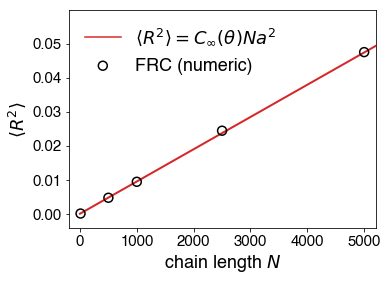

In [40]:
# visualization of the same result, using the vectorized FRC code
sampleLengths_ex4 = np.array([10, 500, 1000, 2500, 5000])
msd_ex4_vec = get_msd(X_ex4_vec, Y_ex4_vec, sampleLengths_ex4)
plot_msd_FRC(sampleLengths_ex4, msd_ex4_vec)

The proportionalty factor here is Flory's characteristic ratio $C_{\infty}$, which for the freely rotating chain model is
\begin{align}
C_{\infty}(\theta) = \dfrac{1+\cos(\theta)}{1-\cos(\theta)} \, .
\end{align}
With this, the MSD for the FRC model is of course
\begin{align}
\bigl\langle
\boldsymbol{R}^2\,\bigl\rangle = C_{\infty}(\theta)Na^2 = \dfrac{1+\cos(\theta)}{1-\cos(\theta)}\, Na^2 \, .
\end{align}

## Assay 5 FRC mean-squared-end-to-end vector as a function of the rotation angle $\theta$

In [41]:
%%time
np.random.seed(123456789)
m = 1000 # number of independent configurations
N = 2000

sampleLengths_ex5 = np.array([N])

thetas = np.array([0.02 * np.pi, 0.05 * np.pi,\
                   0.1 * np.pi, 0.3 * np.pi, 0.6 * np.pi, np.pi])

res_ex5 = np.zeros((len(thetas)))

for i, theta in enumerate(thetas):
    print("theta", theta)
    tmpX, tmpY = FRC(sampleLengths_ex5, m, a = 1.0e-3, theta = theta)
    tmpMSD = get_msd(tmpX, tmpY, sampleLengths_ex5)
    res_ex5[i] = tmpMSD[0]

np.savetxt('./assay_5_msd.txt', res_ex5, fmt = '%.8f')

theta 0.06283185307179587
totalIterations =  2000
theta 0.15707963267948966
totalIterations =  2000
theta 0.3141592653589793
totalIterations =  2000
theta 0.9424777960769379
totalIterations =  2000
theta 1.8849555921538759
totalIterations =  2000
theta 3.141592653589793
totalIterations =  2000
CPU times: user 3min 47s, sys: 2.35 s, total: 3min 49s
Wall time: 3min 54s


In [43]:
file = './assay_5_msd.txt'
res_ex5 = np.genfromtxt(file)
print(res_ex5.shape)

(6,)


In [44]:
%%time
np.random.seed(123456789)
m = 1000 # number of independent configurations
N = 2000

sampleLengths_ex5 = np.array([N])

thetas = np.array([0.02 * np.pi, 0.05 * np.pi,\
                   0.1 * np.pi, 0.3 * np.pi, 0.6 * np.pi, np.pi])

res_ex5_vec = np.zeros((len(thetas)))

for i, theta in enumerate(thetas):
    print("theta", theta)
    tmpX, tmpY = FRC_wrapper(sampleLengths_ex5, m, a = 1.0e-3, theta = theta)
    tmpMSD = get_msd(tmpX, tmpY, sampleLengths_ex5)
    res_ex5_vec[i] = tmpMSD[0]

theta 0.06283185307179587
theta 0.15707963267948966
theta 0.3141592653589793
theta 0.9424777960769379
theta 1.8849555921538759
theta 3.141592653589793
CPU times: user 1.2 s, sys: 16.4 ms, total: 1.22 s
Wall time: 1.24 s


In [45]:
def plot_msd_FRC_theta(X, Y, N = 2000.0, a = 1.0e-3):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel(r'rotation angle $\theta$', fontsize = 18)
    ax.set_ylabel(r'$\langle R^2\rangle$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    xVals = np.linspace(0.05, 1.2 * np.pi, 500)
    yVals = np.array([N * a ** 2 * FloryC(theta) for theta in xVals])
    ax.plot(xVals, yVals, 
            lw = 2.0, 
            color = 'C3', 
            label = r'$\langle R^2\rangle = C_{\infty}(\theta)Na^2$',
            zorder = 1)
    ax.scatter(X, Y, color = 'k', 
               s = 80,
               marker = 'o',
               facecolors = 'None',
               edgecolors = 'k',
               linewidth = 1.5,
               zorder = 2,
               label = r'FRC (numeric)')

    ax.set_xlim(-0.1, 1.05 * np.pi)
    ax.set_ylim(-0.085, 2.0062)
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

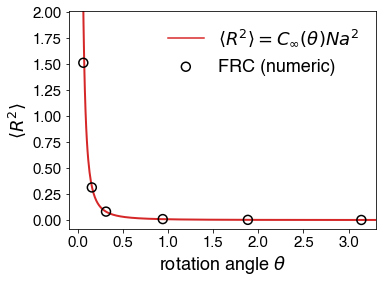

In [46]:
thetas = np.array([0.02 * np.pi, 0.05 * np.pi,\
                   0.1 * np.pi, 0.3 * np.pi, 0.6 * np.pi, np.pi])
plot_msd_FRC_theta(thetas, res_ex5, N = 2000.0)

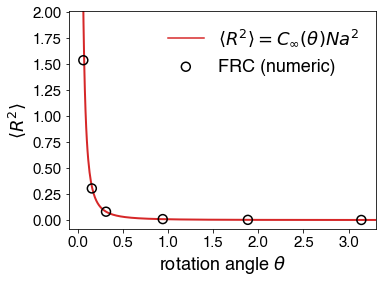

In [47]:
# visualization of the same result using the vectorized version of the FRC model
thetas = np.array([0.02 * np.pi, 0.05 * np.pi,\
                   0.1 * np.pi, 0.3 * np.pi, 0.6 * np.pi, np.pi])
plot_msd_FRC_theta(thetas, res_ex5_vec, N = 2000.0)

In [48]:
def plot_msd_FRC_theta_LOG(X, Y, N = 2000.0, a = 1.0e-3):
    
    f, ax = plt.subplots(1)
    f.set_size_inches(5.5, 4.0)
    
    ax.set_xlabel(r'rotation angle $\theta$', fontsize = 18)
    ax.set_ylabel(r'$\langle R^2\rangle$', fontsize = 18)
    labelfontsize = 15.0
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(labelfontsize)
    
    xVals = np.linspace(0.01, 1.2 * np.pi, 500)
    yVals = np.array([N * a ** 2 * FloryC(theta) for theta in xVals])
    ax.plot(xVals, yVals, 
            lw = 2.0, 
            color = 'C3', 
            label = r'$\langle R^2\rangle = C_{\infty}(\theta)Na^2$',
            zorder = 1)
    ax.scatter(X, Y, color = 'k', 
               s = 80,
               marker = 'o',
               facecolors = 'None',
               edgecolors = 'k',
               linewidth = 1.5,
               zorder = 2,
               label = r'FRC (numeric)')

    ax.set_xlim(-0.1, 1.05 * np.pi)
    ax.set_ylim(1.0e-9, 5.1)
    
    ax.set_yscale('log')
    
    leg = ax.legend(scatterpoints = 1,
                     markerscale = 1.0,
                     ncol = 1,
                     fontsize = 18)
    for i, legobj in enumerate(leg.legendHandles):
        legobj.set_linewidth(1.5)
    leg.draw_frame(False)
    return None

In [49]:
%%time
np.random.seed(123456789)
m = 10000 # number of independent configurations
N = 2000

sampleLengths_ex6 = np.array([N])

thetas = np.array([0.02 * np.pi, 0.05 * np.pi,\
                   0.1 * np.pi, 0.2 * np.pi, 0.3 * np.pi, 0.4 * np.pi,\
                   0.5 * np.pi, 0.6 * np.pi, 0.7 * np.pi, 0.8 * np.pi,\
                   0.9 * np.pi, 0.95 * np.pi, 0.98 * np.pi, 0.99 * np.pi])

res_ex6_vec = np.zeros((len(thetas)))

for i, theta in enumerate(thetas):
    print("theta", theta)
    tmpX, tmpY = FRC_wrapper(sampleLengths_ex6, m, a = 1.0e-3, theta = theta)
    tmpMSD = get_msd(tmpX, tmpY, sampleLengths_ex6)
    res_ex6_vec[i] = tmpMSD[0]

theta 0.06283185307179587
theta 0.15707963267948966
theta 0.3141592653589793
theta 0.6283185307179586
theta 0.9424777960769379
theta 1.2566370614359172
theta 1.5707963267948966
theta 1.8849555921538759
theta 2.199114857512855
theta 2.5132741228718345
theta 2.827433388230814
theta 2.9845130209103035
theta 3.078760800517997
theta 3.1101767270538954
CPU times: user 26.6 s, sys: 191 ms, total: 26.7 s
Wall time: 27.1 s


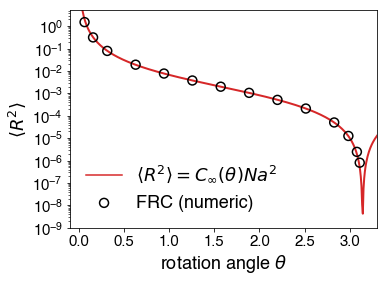

In [50]:
# visualization of the same result using the vectorized version of the FRC model
thetas = np.array([0.02 * np.pi, 0.05 * np.pi,\
                   0.1 * np.pi, 0.2 * np.pi, 0.3 * np.pi, 0.4 * np.pi,\
                   0.5 * np.pi, 0.6 * np.pi, 0.7 * np.pi, 0.8 * np.pi,\
                   0.9 * np.pi, 0.95 * np.pi, 0.98 * np.pi, 0.99 * np.pi])
plot_msd_FRC_theta_LOG(thetas, res_ex6_vec, N = 2000.0)
# print(res_ex6_vec)

In this assay we used the fact that the characteristic ratio
\begin{align}
C_{\infty}(\theta) = \dfrac{1+\cos\theta}{1-\cos\theta} \, .
\end{align}
For small $\theta$ we can Taylor expand this expression and equally work with
\begin{align}
C_{\infty}(\theta) = \dfrac{4}{\theta^2} - 1 + \mathcal{O}\left(\theta^3\right) \simeq \dfrac{4}{\theta^2} - 1 \, .
\end{align}
This additionally shows us that the apparent divergence of $C_{\infty}$ in the $\theta\rightarrow 0$ limit scales as $\theta^{-2}$.